<a href="https://colab.research.google.com/github/sharma-aarti/RL/blob/main/Autonomous_Drone_Swarm_Navigation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install gymnasium --quiet
!pip install stable-baselines3[extra] --quiet
!pip install matplotlib --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 23.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.9 MB/s eta 0:00:00


In [14]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import random
import matplotlib.pyplot as plt

# Multi-agent 2D grid environment class
class DroneSwarmEnv(gym.Env):
    def __init__(self, grid_size=10, n_drones=3, n_obstacles=5):
        super(DroneSwarmEnv, self).__init__()

        self.grid_size = grid_size
        self.n_drones = n_drones
        self.n_obstacles = n_obstacles

        # Action space: each drone can move in 4 directions [up, down, left, right]
        self.action_space = spaces.MultiDiscrete([4] * self.n_drones)

        # Observation space: for each drone, we track its (x, y) position on the grid
        self.observation_space = spaces.Box(low=0, high=self.grid_size-1, shape=(self.n_drones, 2), dtype=np.int32)

        # Initialize drones, obstacles, and goals
        self.seed()

    def seed(self, seed=None):
        random.seed(seed)
        np.random.seed(seed)

    def reset(self, seed=None, options=None):
        # Set the seed
        super().reset(seed=seed)
        self.seed(seed)

        self.drones = np.array([self._random_position() for _ in range(self.n_drones)], dtype=np.int32)
        self.obstacles = [self._random_position() for _ in range(self.n_obstacles)]
        self.goals = np.array([self._random_position() for _ in range(self.n_drones)], dtype=np.int32)

        return self.drones, {}

    def _random_position(self):
        return [random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1)]

    def step(self, actions):
      rewards = []
      for i, action in enumerate(actions):
        # Store previous position to calculate distance change
        prev_position = np.array(self.drones[i])

        # Move the drone based on the action
        if action == 0 and self.drones[i][1] > 0:  # Move up
            self.drones[i][1] -= 1
        elif action == 1 and self.drones[i][1] < self.grid_size - 1:  # Move down
            self.drones[i][1] += 1
        elif action == 2 and self.drones[i][0] > 0:  # Move left
            self.drones[i][0] -= 1
        elif action == 3 and self.drones[i][0] < self.grid_size - 1:  # Move right
            self.drones[i][0] += 1

        # Calculate distance-based reward
        current_position = np.array(self.drones[i])
        goal_position = np.array(self.goals[i])
        prev_distance = np.linalg.norm(prev_position - goal_position)
        current_distance = np.linalg.norm(current_position - goal_position)

        # Reward for reducing distance to the goal
        distance_reward = prev_distance - current_distance

        # Bonus for reaching the goal
        if np.array_equal(self.drones[i], self.goals[i]):
            rewards.append(10.0)  # Keep the goal reward
        else:
            rewards.append(distance_reward - 0.1)  # Penalize for each step (small negative step penalty)

    # Check if all drones reached their goals
      done = all([np.array_equal(self.drones[i], self.goals[i]) for i in range(self.n_drones)])

      return self.drones.astype(np.int32), float(np.sum(rewards)), done, False, {}


    def render(self):
        grid = np.zeros((self.grid_size, self.grid_size), dtype=str)
        grid[:] = '.'

        # Place drones
        for i, drone in enumerate(self.drones):
            grid[drone[1], drone[0]] = 'D'  # D represents Drone

        # Place obstacles
        for obstacle in self.obstacles:
            grid[obstacle[1], obstacle[0]] = 'X'  # X represents Obstacle

        # Place goals
        for i, goal in enumerate(self.goals):
            grid[goal[1], goal[0]] = 'G'  # G represents Goal

        print("\n".join(" ".join(row) for row in grid))
        print("\n")

# Create the environment
env = DroneSwarmEnv(grid_size=10, n_drones=3, n_obstacles=5)

# Test the environment by resetting and rendering
obs, _ = env.reset()
env.render()

# Take random actions and observe the environment's response
actions = env.action_space.sample()  # Random actions
obs, reward, done, truncated, info = env.step(actions)
env.render()

print("Actions taken:", actions)
print("Reward:", reward)


. . . . . . . . . .
. . . . . . . . . .
. . X . . . . . . G
. D . . . . . . . .
. . . G X . G . . .
. . . . . X . . . .
. . . . . . . . . .
. D . . . . . . . .
. . . . X . . . . D
. . . . . . . . . .


. . . . . . . . . .
. . . . . . . . . .
. D X . . . . . . G
. . . . . . . . . .
. . . G X . G . . .
. . . . . X . . . .
. . . . . . . . . .
D . . . . . . . . .
. . . . X . . . . .
. . . . . . . . . D


Actions taken: [0 2 1]
Reward: -2.223234705197015


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

# Check if the environment is correctly implemented
check_env(env, warn=True)

# Define the PPO model
model = PPO("MlpPolicy", env, learning_rate=0.0003, batch_size=64, verbose=1)

# Train the PPO agent for 50,000 timesteps
model.learn(total_timesteps=50000)

# Save the trained model
model.save("ppo_drone_swarm")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/env_checker.py:263: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 332  |
|    iterations      | 1    |
|    time_elapsed    | 6    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 276         |
|    iterations           | 2           |
|    time_elapsed         | 14          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011658844 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.15       |
|    explained_variance   | -0.00251    |
|    learning_rate        | 0.0003      |
|    loss                 | 13.6        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0191     |
|    value_loss        

In [16]:
# Load the trained model
model = PPO.load("ppo_drone_swarm")

# Reset the environment
obs, _ = env.reset()
env.render()

# Let the model take actions and visualize the drone movement for 10 steps
for i in range(10):
    # Predict the next action for the swarm of drones
    action, _ = model.predict(obs)

    # Take a step in the environment based on the predicted action
    obs, reward, terminated, truncated, info = env.step(action)

    # Render the updated state of the environment
    env.render()

    # If all drones have reached their goals, break the loop
    if terminated:
        print("All drones reached their goals!")
        break


. . . . . . . G . .
. G . . . . . . . .
. X . . . . . . . .
. . . . . . . . . .
. . . . X . . . . G
. . X . . . . . . .
. . . . D . . . . .
. X . . . . . . . .
. . . . X . . D . .
. D . . . . . . . .


. . . . . . . G . .
. G . . . . . . . .
. X . . . . . . . .
. . . . . . . . . .
. . . . X . . . . G
. . X . D . . . . .
. . . . . . . . . .
. X . . . . . D . .
. . . . X . . . . .
. . D . . . . . . .


. . . . . . . G . .
. G . . . . . . . .
. X . . . . . . . .
. . . . . . . . . .
. . . . X . . . . G
. . X . . . . . . .
. . . . D . . . . .
. X . . . . D . . .
. . . . X . . . . .
. . . D . . . . . .


. . . . . . . G . .
. G . . . . . . . .
. X . . . . . . . .
. . . . . . . . . .
. . . . X . . . . G
. . X . D . . . . .
. . . . . . . . . .
. X . . . D . . . .
. . . . X . . . . .
. . . . D . . . . .


. . . . . . . G . .
. G . . . . . . . .
. X . . . . . . . .
. . . . . . . . . .
. . . . X . . . . G
. . X . . . . . . .
. . . . D . . . . .
. X . . . . . . . .
. . . . X D . . . .
. . . . . D 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


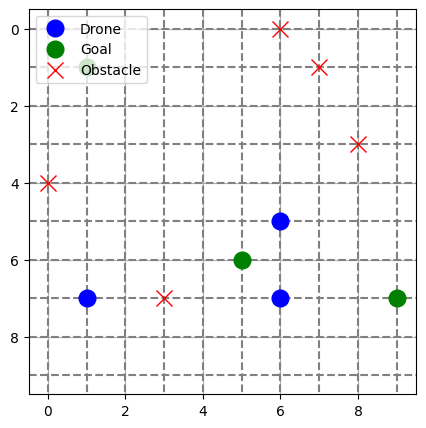

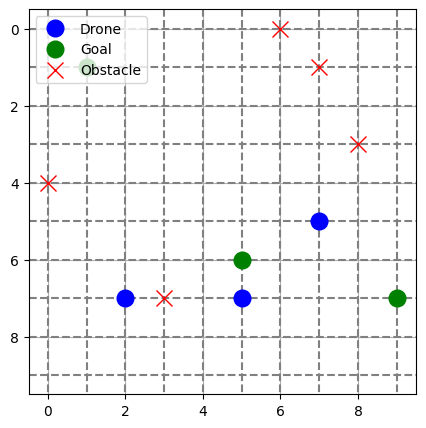

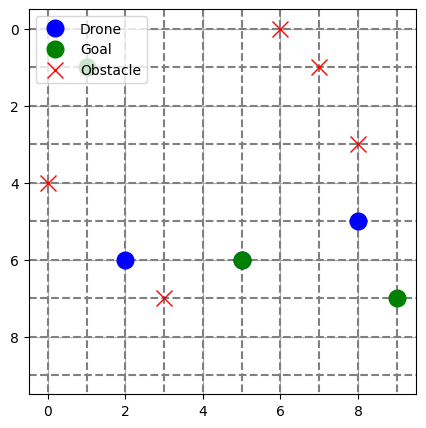

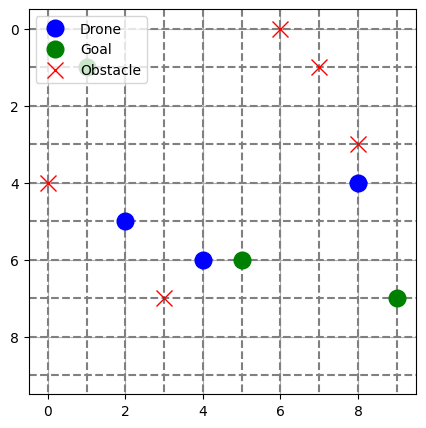

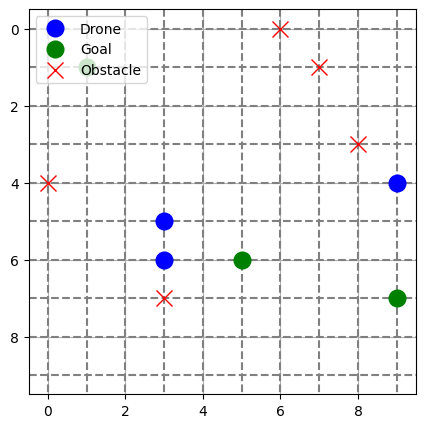

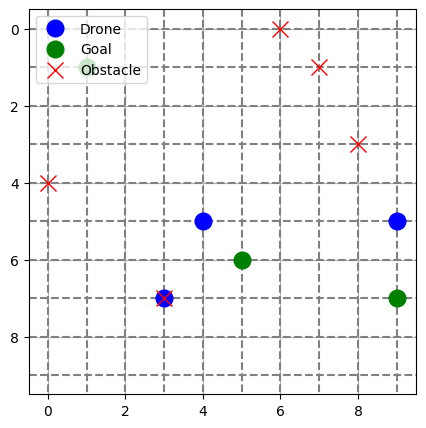

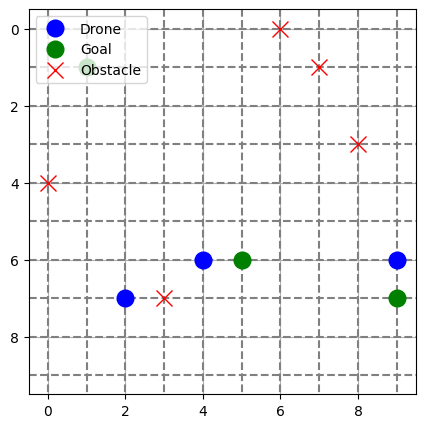

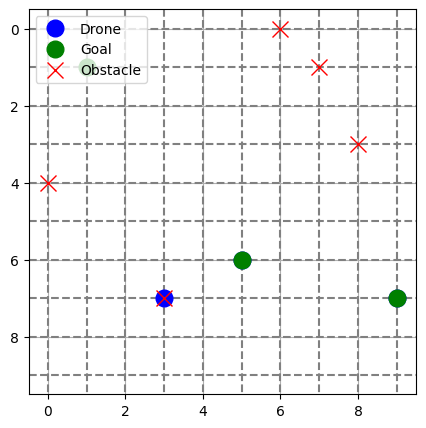

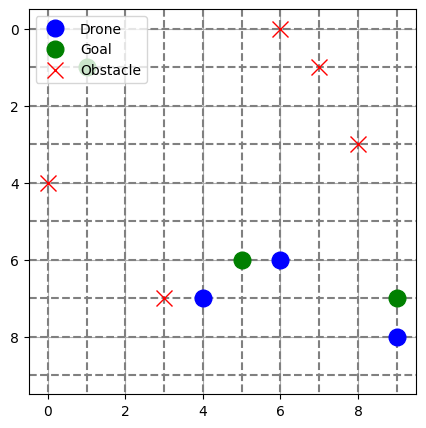

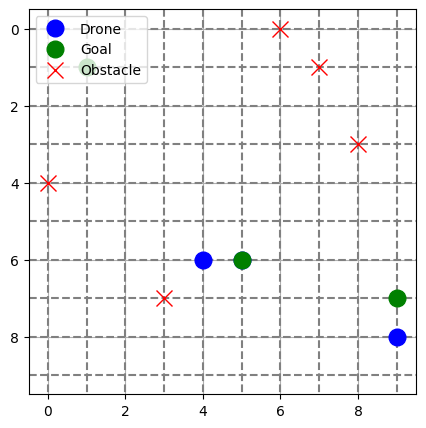

In [26]:
# Helper function to plot the grid environment with proper labels and legends
def plot_grid(drones, goals, obstacles, grid_size):
    plt.figure(figsize=(5, 5))
    plt.xlim(-0.5, grid_size - 0.5)
    plt.ylim(-0.5, grid_size - 0.5)

    # Plot grid lines
    for x in range(grid_size):
        plt.plot([x, x], [-0.5, grid_size - 0.5], color='gray', linestyle='--')
    for y in range(grid_size):
        plt.plot([-0.5, grid_size - 0.5], [y, y], color='gray', linestyle='--')

    # Plot drones (with label for the first drone only)
    for i, drone in enumerate(drones):
        if i == 0:
            plt.plot(drone[0], drone[1], 'bo', markersize=12, label='Drone')
        else:
            plt.plot(drone[0], drone[1], 'bo', markersize=12)

    # Plot goals (with label for the first goal only)
    for i, goal in enumerate(goals):
        if i == 0:
            plt.plot(goal[0], goal[1], 'go', markersize=12, label='Goal')
        else:
            plt.plot(goal[0], goal[1], 'go', markersize=12)

    # Plot obstacles (with label for the first obstacle only)
    for i, obstacle in enumerate(obstacles):
        if i == 0:
            plt.plot(obstacle[0], obstacle[1], 'rx', markersize=12, label='Obstacle')
        else:
            plt.plot(obstacle[0], obstacle[1], 'rx', markersize=12)

    plt.grid(True)
    plt.gca().invert_yaxis()  # Invert y-axis for better alignment with matrix coordinates

    # Add the legend to the plot
    plt.legend(loc='upper left')
    plt.show()

# Visualize the trained model's drone movement
obs, _ = env.reset()
for i in range(10):
    action, _ = model.predict(obs)
    obs, reward, terminated, truncated, info = env.step(action)

    # Use the plotting function to visualize the grid state
    plot_grid(env.drones, env.goals, env.obstacles, env.grid_size)

    if terminated:
        print("All drones reached their goals!")
        break


In [27]:
# Evaluate the trained model over multiple episodes with a step limit
def evaluate_model(model, env, n_episodes=20, max_steps_per_episode=100):
    total_rewards = []

    for episode in range(n_episodes):
        obs, _ = env.reset()
        episode_reward = 0
        step_count = 0

        while True:
            action, _ = model.predict(obs)
            obs, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward
            step_count += 1

            # Check if episode is terminated, truncated, or max steps exceeded
            if terminated or truncated or step_count >= max_steps_per_episode:
                print(f"Episode {episode + 1} finished after {step_count} steps.")
                break

        total_rewards.append(episode_reward)
        print(f"Episode {episode + 1}: Total Reward = {episode_reward}")

    avg_reward = np.mean(total_rewards)
    print(f"Average Reward over {n_episodes} episodes: {avg_reward}")

# Evaluate the trained PPO model with a max of 100 steps per episode
evaluate_model(model, env, n_episodes=20, max_steps_per_episode=100)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Episode 1 finished after 100 steps.
Episode 1: Total Reward = 142.4197165896623
Episode 2 finished after 100 steps.
Episode 2: Total Reward = -28.61425971874124
Episode 3 finished after 100 steps.
Episode 3: Total Reward = -27.073981078248845
Episode 4 finished after 100 steps.
Episode 4: Total Reward = -31.230071550918215
Episode 5 finished after 100 steps.
Episode 5: Total Reward = -4.481146352750041
Episode 6 finished after 100 steps.
Episode 6: Total Reward = -29.590070344508998
Episode 7 finished after 100 steps.
Episode 7: Total Reward = -33.364316103149285
Episode 8 finished after 100 steps.
Episode 8: Total Reward = -36.95892206495678
Episode 9 finished after 100 steps.
Episode 9: Total Reward = -17.659835089481597
Episode 10 finished after 100 steps.
Episode 10: Total Reward = -14.828932188134525
Episode 11 finished after 100 steps.
Episode 11: Total Reward = 9.478427174626157
Episode 12 finished after 100 steps.
Episode 12: Total Reward = -39.47834050741707
Episode 13 finishe

In [28]:
# Save the model to Google Drive or local storage
model.save("/content/ppo_drone_swarm")

# Load the saved model
model = PPO.load("/content/ppo_drone_swarm")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
from stable_baselines3.common.monitor import Monitor

# Wrap the environment with a monitor for logging
env = Monitor(env, filename="drone_swarm_logs")

# Train the PPO model with logging
model = PPO("MlpPolicy", env, learning_rate=0.0003, batch_size=64, verbose=1)
model.learn(total_timesteps=50000)

# Save the logs to a file for later analysis
import pandas as pd
log_data = pd.read_csv("drone_swarm_logs.monitor.csv")
log_data.head()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Using cuda device
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 296  |
|    iterations      | 1    |
|    time_elapsed    | 6    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 271         |
|    iterations           | 2           |
|    time_elapsed         | 15          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012574901 |
|    clip_fraction        | 0.18        |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.15       |
|    explained_variance   | 0.0143      |
|    learning_rate        | 0.0003      |
|    loss                 | 24.5        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0246     |
|    value_loss           | 40.8        |
-----------------------

,"#{""t_start"": 1727691884.1445856","""env_id"": ""None""}"
r,l,t
16746.741619,15702,64.862905


In [32]:
!pip install shap --quiet


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 29.4 MB/s eta 0:00:00


In [36]:
import shap
import numpy as np

# Define a prediction function for SHAP to wrap around the PPO model
def ppo_predict(obs):
    """
    This function will use the trained PPO model to predict actions
    based on the observations (drone states).
    """
    obs = obs.reshape((-1,) + env.observation_space.shape)  # Ensure correct shape for observations
    action, _ = model.predict(obs, deterministic=False)     # Get action predictions from PPO model
    return action

# Generate sample data for SHAP (we'll use observations from the environment)
def get_sample_data(env, n_samples=100):
    """
    Collect sample observations from the environment for SHAP analysis.
    """
    observations = []
    for _ in range(n_samples):
        obs, _ = env.reset()  # Reset the environment and get the initial observation
        observations.append(obs.flatten())  # Flatten the observation to match SHAP requirements
    return np.array(observations)

# Generate sample observations from the environment
sample_data = get_sample_data(env, n_samples=100)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
# Check the shape of the observations in sample_data
print(f"Sample data shape: {sample_data.shape}")


Sample data shape: (100, 6)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
# import shap
# import numpy as np

# # Define a prediction function that wraps around the PPO model
# # Define a prediction function that wraps around the PPO model
# def ppo_predict(obs):
#     # Ensure obs is in the right shape for the model
#     obs = obs.reshape((-1,) + env.observation_space.shape)  # Reshape obs if needed

#     # Get action probabilities (use deterministic=False to get stochastic action distribution)
#     action_probs, _ = model.predict(obs, deterministic=False)

#     # If action_probs is a scalar, reshape it into a 2D array to comply with SHAP's requirements
#     if np.isscalar(action_probs):
#         action_probs = np.array([action_probs])

#     return action_probs


# # Generate some sample observations from the environment for SHAP analysis
# # Generate some sample observations from the environment for SHAP analysis
# def get_sample_data(env, n_samples=100):
#     observations = []
#     for _ in range(n_samples):
#         obs, _ = env.reset()  # Reset the environment to get a new observation
#         observations.append(obs.flatten())  # Flatten the observation to make it 2D
#     return np.array(observations)


# # Get sample observations from the environment
# sample_data = get_sample_data(env, n_samples=100)

# # Use SHAP's KernelExplainer for black-box models like PPO
# explainer = shap.KernelExplainer(ppo_predict, sample_data)

# # Compute SHAP values for the first observation in the sample dataset
# shap_values = explainer.shap_values(sample_data[:1])  # Explain the first observation

# # Plot the SHAP values
# shap.plots.force(explainer.expected_value, shap_values[0])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/shap/explainers/_kernel.py:640: DeprecationWarning: l1_reg='auto' is deprecated and in a future version the behavior will change from a conditional use of AIC to simply a fixed number of top features. Pass l1_reg='num_features(10)' to opt-in to the new default behaviour.
  warnings.warn(


TypeError: In v0.20, force plot now requires the base value as the first parameter! Try shap.plots.force(explainer.expected_value, shap_values) or for multi-output models try shap.plots.force(explainer.expected_value[0], shap_values[..., 0]).

In [37]:
# Initialize SHAP's KernelExplainer using the sample observations and the PPO prediction function
explainer = shap.KernelExplainer(ppo_predict, sample_data)

# Compute SHAP values for the first observation (explaining the model's prediction for the first observation)
shap_values = explainer.shap_values(sample_data[:1])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/shap/explainers/_kernel.py:640: DeprecationWarning: l1_reg='auto' is deprecated and in a future version the behavior will change from a conditional use of AIC to simply a fixed number of top features. Pass l1_reg='num_features(10)' to opt-in to the new default behaviour.
  warnings.warn(


In [47]:
# Check the shape of shap_values and sample_data
print(f"SHAP values shape: {np.array(shap_values).shape}")
print(f"Sample data shape: {sample_data.shape}")


SHAP values shape: (1, 6, 3)
Sample data shape: (100, 6)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
# Check the shape of the SHAP values to understand the multi-output structure
print(f"SHAP values shape: {np.array(shap_values).shape}")  # Output: (1, 6, 3)


SHAP values shape: (1, 6, 3)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
# Generate feature names for 3 drones (since the sample data has 6 features)
def generate_feature_names():
    feature_names = []

    # Assuming the 6 features are for 3 drones' X and Y positions
    for i in range(3):  # 3 drones
        feature_names.append(f"Drone {i+1} X position")
        feature_names.append(f"Drone {i+1} Y position")

    return feature_names

# Generate the feature names
feature_names = generate_feature_names()

# Check if the number of feature names matches the sample data
print(f"Generated Feature Names: {feature_names}")
print(f"Number of feature names: {len(feature_names)}")
print(f"Number of features in the sample data: {sample_data.shape[1]}")

assert len(feature_names) == sample_data.shape[1], "Feature names do not match the number of features in the observation!"


Generated Feature Names: ['Drone 1 X position', 'Drone 1 Y position', 'Drone 2 X position', 'Drone 2 Y position', 'Drone 3 X position', 'Drone 3 Y position']
Number of feature names: 6
Number of features in the sample data: 6


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
# Visualize SHAP values for the first action (first drone) using SHAP's force plot
shap.initjs()

# Index to select the SHAP values for the first action (drone 1)
shap.force_plot(explainer.expected_value[0], shap_values[0][:, 0], feature_names)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [54]:
# Visualize SHAP values for the second drone's action
shap.initjs()

shap.force_plot(explainer.expected_value[1], shap_values[0][:, 1], feature_names)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
# Visualize SHAP values for the third drone's action
shap.initjs()

shap.force_plot(explainer.expected_value[2], shap_values[0][:, 2], feature_names)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [58]:
# Compute SHAP values for the first 10 samples
shap_values = explainer.shap_values(sample_data[:10])  # Generate SHAP values for 10 samples


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/shap/explainers/_kernel.py:640: DeprecationWarning: l1_reg='auto' is deprecated and in a future version the behavior will change from a conditional use of AIC to simply a fixed number of top features. Pass l1_reg='num_features(10)' to opt-in to the new default behaviour.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/shap/explainers/_kernel.py:640: DeprecationWarning: l1_reg='auto' is deprecated and in a future version the behavior will change from a conditional use of AIC to simply a fixed number of top features. Pass l1_reg='num_features(10)' to opt-in to the new default behaviour.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


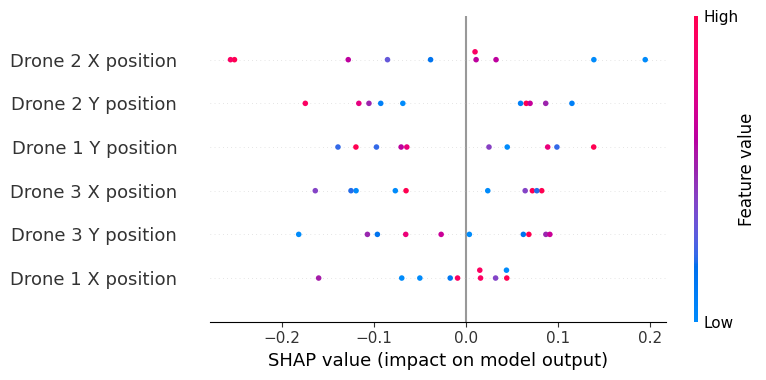

In [59]:
# Select the SHAP values for the first output (action of the first drone)
shap_values_for_first_action = shap_values[:, :, 0]  # Extract SHAP values for first action (10 samples, 6 features)

# Generate a SHAP summary plot for the first action
shap.summary_plot(shap_values_for_first_action, sample_data[:10], feature_names=feature_names)


In [60]:
# Compute SHAP values for the first 10 samples
shap_values = explainer.shap_values(sample_data[:10])  # Generate SHAP values for 10 samples

# Check the shape of SHAP values to ensure correctness
print(f"SHAP values shape: {np.array(shap_values).shape}")  # Expected: (10, 6, 3) for 10 samples, 6 features, 3 outputs


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/shap/explainers/_kernel.py:640: DeprecationWarning: l1_reg='auto' is deprecated and in a future version the behavior will change from a conditional use of AIC to simply a fixed number of top features. Pass l1_reg='num_features(10)' to opt-in to the new default behaviour.
  warnings.warn(


SHAP values shape: (10, 6, 3)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


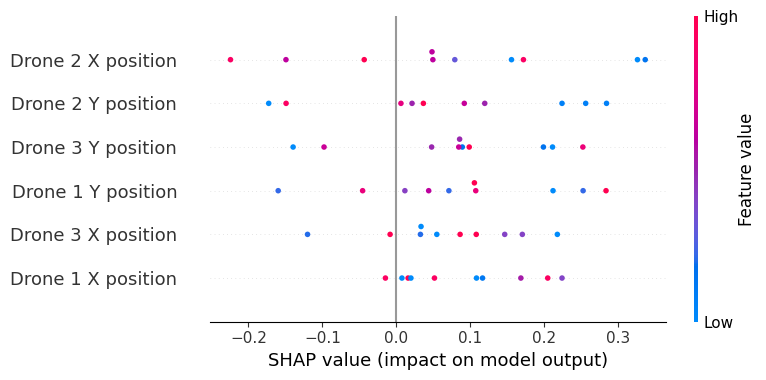

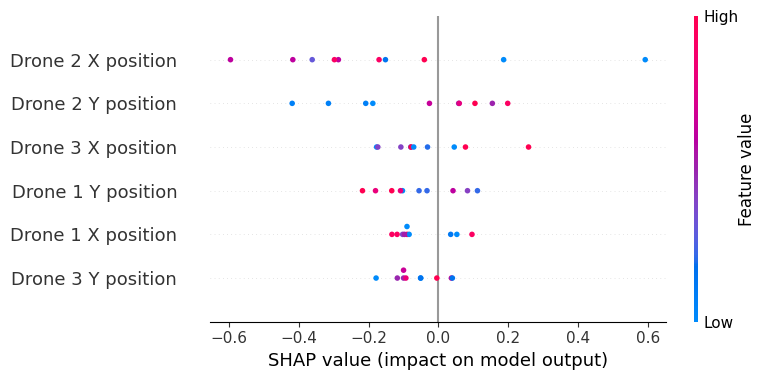

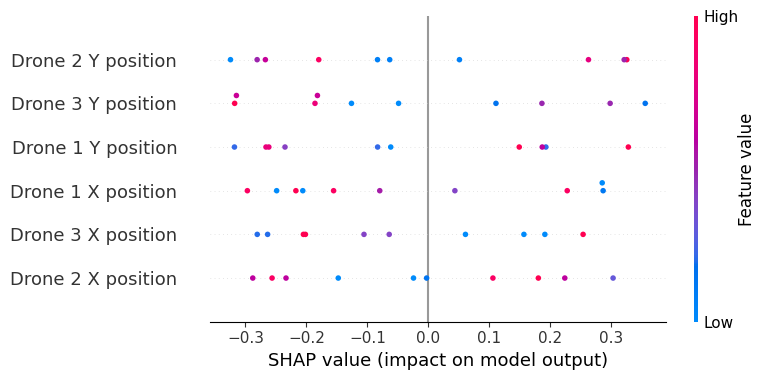

In [61]:
# Feature names (assumed to be for 3 drones' X and Y positions)
feature_names = generate_feature_names()

# SHAP summary plot for the first action (Drone 1)
shap_values_for_first_action = shap_values[:, :, 0]  # Extract SHAP values for the first action (10 samples, 6 features)
shap.summary_plot(shap_values_for_first_action, sample_data[:10], feature_names=feature_names)

# SHAP summary plot for the second action (Drone 2)
shap_values_for_second_action = shap_values[:, :, 1]  # Extract SHAP values for the second action (10 samples, 6 features)
shap.summary_plot(shap_values_for_second_action, sample_data[:10], feature_names=feature_names)

# SHAP summary plot for the third action (Drone 3)
shap_values_for_third_action = shap_values[:, :, 2]  # Extract SHAP values for the third action (10 samples, 6 features)
shap.summary_plot(shap_values_for_third_action, sample_data[:10], feature_names=feature_names)
